In [ ]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

load_dotenv()
file_path = os.getenv("FILE_PATH")
SNP_prices_file = './data/S&P 500 Index.csv'


### S&P500 Prices

In [2]:
# Load the CSV file into df
SNP = pd.read_csv(SNP_prices_file)
SNP.columns = ["date", "price"]
SNP["date"] = pd.to_datetime(SNP["date"])
SNP = SNP.set_index("date")
SNP = SNP.sort_index(ascending=True)

# Calculating log prices
SNP["log_returns"] = np.log(SNP["price"]/ SNP["price"].shift(1))
SNP = SNP[1:]
SNP.head()

,price,log_returns
date,,
2015-01-05,2020.58,-0.018447
2015-01-06,2002.61,-0.008933
2015-01-07,2025.90,0.011563
2015-01-08,2062.14,0.017730
2015-01-09,2044.81,-0.008439


In [3]:
from hurst import compute_Hc
import plotly.graph_objects as go

def compute_rolling_hurst(df, window, col='log_returns', lag=0):
    hurst_values = []
    times = []
    
    # Loop through the DataFrame using the rolling window
    for i in range(window - 1, len(df), lag+1):

        # Extract the window slice from the series
        window_series = df[col].iloc[i - window + 1 : i + 1: lag+1]
        
        # Compute the Hurst exponent using the 'change' method and simplified calculation
        h, c, data = compute_Hc(window_series, kind='change', simplified=True)
        
        hurst_values.append(h)
        times.append(df.index[i])
    
    # Create and return a new DataFrame with the computed Hurst exponents
    result_df = pd.DataFrame({'hurst': hurst_values}, index=times)
    return result_df

hurst_window250_lag0 = compute_rolling_hurst(SNP, window=250, col='log_returns', lag=0)
hurst_window350_lag0 = compute_rolling_hurst(SNP, window=350, col='log_returns', lag=0)
hurst_window500_lag0 = compute_rolling_hurst(SNP, window=500, col='log_returns', lag=0)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=hurst_window250_lag0.index,
    y=hurst_window250_lag0["hurst"],
    mode='lines',
    name='250 days rolling window',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=hurst_window350_lag0.index,
    y=hurst_window350_lag0["hurst"],
    mode='lines',
    name='350 days rolling window',
    line=dict(color='red')
))
fig.add_trace(go.Scatter(
    x=hurst_window500_lag0.index,
    y=hurst_window500_lag0["hurst"],
    mode='lines',
    name='500 days rolling window',
    line=dict(color='green')
))
fig.update_layout(
    title=f"Hurst exponent for SNP",
    xaxis_title="Date",
    yaxis_title="Hurst Value",
    template="plotly_white"
)

### Hit Ratios

In [ ]:
import diagnostics

hit_250_0_df = SNP.join(hurst_window250_lag0, how='inner')
hit_350_0_df = SNP.join(hurst_window350_lag0, how='inner')
hit_500_0_df = SNP.join(hurst_window500_lag0, how='inner')

hit_250_0 = diagnostics.compute_hit_ratio(hit_250_0_df, predicted_col='log_returns')
hit_350_0 = diagnostics.compute_hit_ratio(hit_350_0_df, predicted_col='log_returns')
hit_500_0 = diagnostics.compute_hit_ratio(hit_500_0_df, predicted_col='log_returns')

print(f"Hit Ratios:\n"
      f"- 250-day window (0 lag): {hit_250_0:.2%}\n"
      f"- 350-day window (0 lag): {hit_350_0:.2%}\n"
      f"- 500-day window (0 lag): {hit_500_0:.2%}")

Hit Ratios:
- 250-day window (0 lag): 53.44%
- 350-day window (0 lag): 51.06%
- 500-day window (0 lag): 49.45%


### Run Monte-Carlo simulation on fBM Model

In [ ]:
import utils

snp_obj = utils.SnpDf(SNP)
result_df = utils.apply_rolling_predictions_from_start(snp_obj, '2017-01-01', 250)
result_df["predicted_log_returns"] = np.log(result_df["predicted"] / result_df["predicted"].shift(1))
result_df = result_df[1:]
result_df.head()

252 days...
253 days...
254 days...
255 days...
256 days...
257 days...
258 days...
259 days...
260 days...
261 days...
262 days...
263 days...
264 days...
265 days...
266 days...
267 days...
268 days...
269 days...
270 days...
271 days...
272 days...
273 days...
274 days...
275 days...
276 days...
277 days...
278 days...
279 days...
280 days...
281 days...
282 days...
283 days...
284 days...
285 days...
286 days...
287 days...
288 days...
289 days...
290 days...
291 days...
292 days...
293 days...
294 days...
295 days...
296 days...
297 days...
298 days...
299 days...
300 days...
301 days...
302 days...
303 days...
304 days...
305 days...
306 days...
307 days...
308 days...
309 days...
310 days...
311 days...
312 days...
313 days...
314 days...
315 days...
316 days...
317 days...
318 days...
319 days...
320 days...
321 days...
322 days...
323 days...
324 days...
325 days...
326 days...
327 days...
328 days...
329 days...
330 days...
331 days...
332 days...
333 days...
334 days...
335 

,predicted,predicted_log_returns
2016-01-06,2017.199188,0.001974
2016-01-07,1990.323079,-0.013413
2016-01-08,1941.303510,-0.024937
2016-01-11,1922.131467,-0.009925
2016-01-12,1922.629754,0.000259


In [6]:
merged_df = result_df.join(SNP, how='inner')
merged_df.head()

,predicted,predicted_log_returns,price,log_returns
2016-01-06,2017.199188,0.001974,1990.26,-0.013202
2016-01-07,1990.323079,-0.013413,1943.09,-0.023986
2016-01-08,1941.303510,-0.024937,1922.03,-0.010898
2016-01-11,1922.131467,-0.009925,1923.67,0.000853
2016-01-12,1922.629754,0.000259,1938.68,0.007773


In [7]:
utils.compute_rmse(merged_df, 'predicted_log_returns', 'log_returns')

0.01734173607662354

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=merged_df.index,
    y=merged_df["predicted"],
    mode='lines',
    name='Predicted',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=merged_df.index,
    y=merged_df["price"],
    mode='lines',
    name='Actual',
    line=dict(color='red')
))
fig.update_layout(
    title=f"Predicted vs Actual Price",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_white"
)

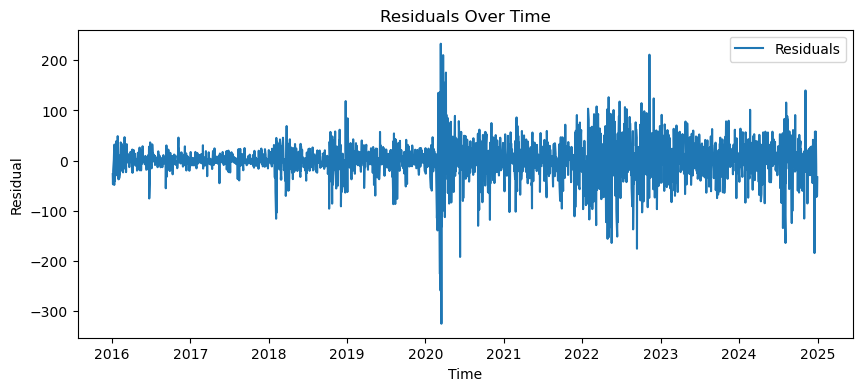

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# 1. Compute the residuals
df = merged_df 
df['residual'] = df['price'] - df['predicted']

# 2. Plot the residuals over time
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['residual'], label='Residuals')
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend()
plt.show()

Observations:
- Large spikes, indicating many outliers 
- Residuals oscillate around zero (good)
- No obvious trend

/Users/benjaminang/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



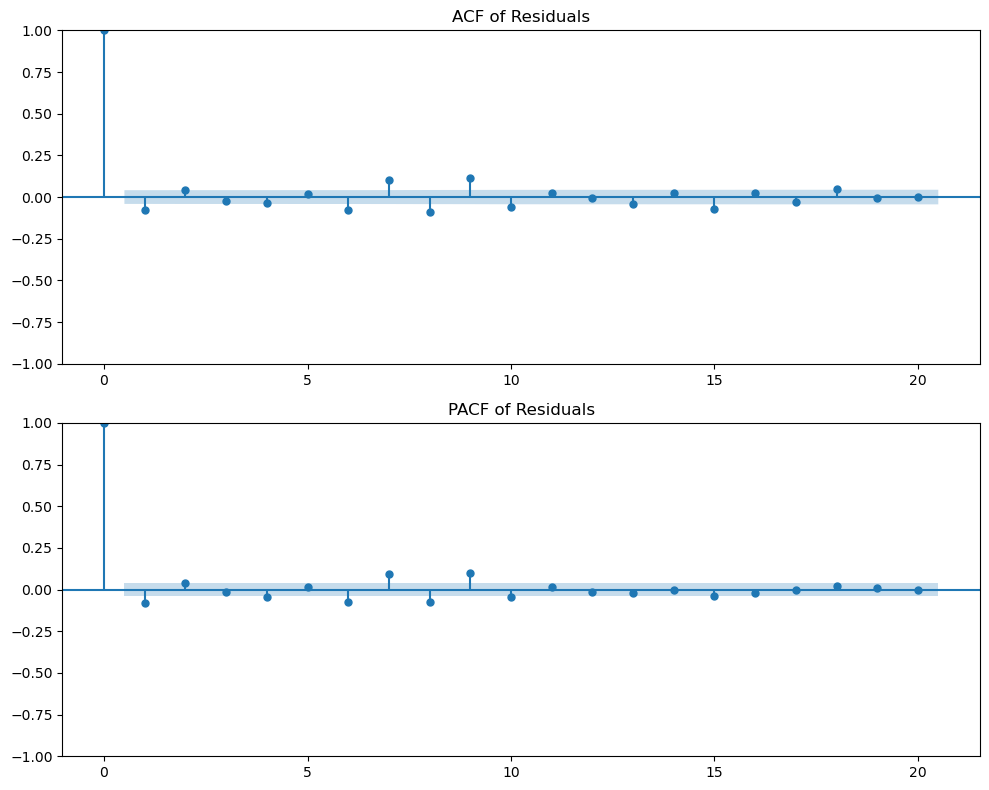

In [10]:
# 3. Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['residual'], lags=20, ax=ax[0])
plot_pacf(df['residual'], lags=20, ax=ax[1])
ax[0].set_title("ACF of Residuals")
ax[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

Observations:
- No signification autocorrelation (since no spikes), captured temporal dependencies well
- Good fit

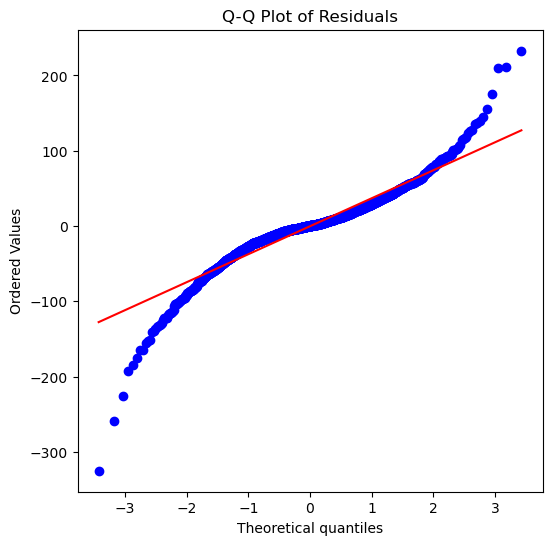

In [11]:
# 4. Q-Q Plot for normality check of the residuals
plt.figure(figsize=(6, 6))
stats.probplot(df['residual'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

Observations:
- Observed heavy tails, indicating that there are outliers
- Non-normal distribution, (probably t distribution)

/Users/benjaminang/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/benjaminang/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



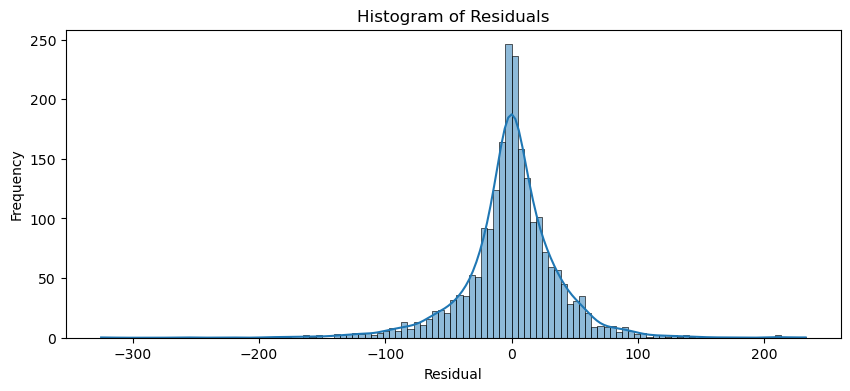

In [12]:
# 5. Histogram of the residuals
plt.figure(figsize=(10, 4))
sns.histplot(df['residual'], kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [13]:
# 6. Perform a normality test (Jarque-Bera Test)
jb_results = diagnostics.perform_jarque_bera_test(SNP['log_returns'].dropna())
print(jb_results)

{'JB Statistic': 26183.337009285806, 'p-value': 0.0, 'Skewness': -0.8105539617739802, 'Kurtosis': 15.757434655527476, 'Normality': 'Reject H0 (Not Normal)'}


Observations:
-  A very small p-value means we reject the null hypothesis that states that residuals are normally distributed.

Thoughts from plots:
- Standard fBM assumes increments follow a normal distribution, but clearly this isn't the case here.

In [14]:
# 7. Perform a autocorrelation test for standardised residuals / residuals squared
from statsmodels.stats.diagnostic import acorr_ljungbox

box_ljung_results = acorr_ljungbox(SNP['log_returns'].dropna(), lags=[10], return_df=True)
box_ljung_squared = acorr_ljungbox(SNP['log_returns'].dropna() ** 2, lags=[10], return_df=True)

print(box_ljung_results)
print(box_ljung_squared)

       lb_stat     lb_pvalue
10  261.798022  1.787261e-50
        lb_stat  lb_pvalue
10  3198.064329        0.0


### Value-at-Risk Forecast

In [ ]:
# Compute 99% parametric VaR
merged_df['VaR_99'] = merged_df['predicted_log_returns'].rolling(250).quantile(0.01)  # 1st percentile

# Compute violation ratio
var_stats = diagnostics.compute_var_violations(merged_df, var_col='VaR_99', predicted_col='log_returns')
print(var_stats)

{'actual_exceedances': 36, 'expected_exceedances': 20.130000000000017, 'violation_ratio': 1.7883755588673607}


In [ ]:
# Visualisation
import plots
plots.plot_var_violations(merged_df, var_col='VaR_99', predicted_col='log_returns')

### Bernoulli Coverage Test

In [ ]:
var_stats = diagnostics.bernoulli_coverage_test(merged_df, var_col='VaR_99', predicted_col='log_returns')
print(var_stats)

(0.0013736277705282962, 10.240870115545988)
